In [199]:
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats.stattools import durbin_watson
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")

In [194]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")

# concat DF
df = pd.concat([X, y], axis=1)
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [150]:
y.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [103]:
iris = load_iris()
X_raw = pd.DataFrame(iris.data, columns=iris.feature_names)

# Scale
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)

# VIF on scaled data
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

print(vif_data)

             Feature        VIF
0  sepal length (cm)   7.072722
1   sepal width (cm)   2.100872
2  petal length (cm)  31.261498
3   petal width (cm)  16.090175


In [105]:
X_reduced = X_scaled.drop(columns=["petal width (cm)"])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_reduced.columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
print(vif_data)

             Feature       VIF
0  sepal length (cm)  6.256954
1   sepal width (cm)  1.839639
2  petal length (cm)  7.557780


In [106]:
X_reduced.shape

(150, 3)

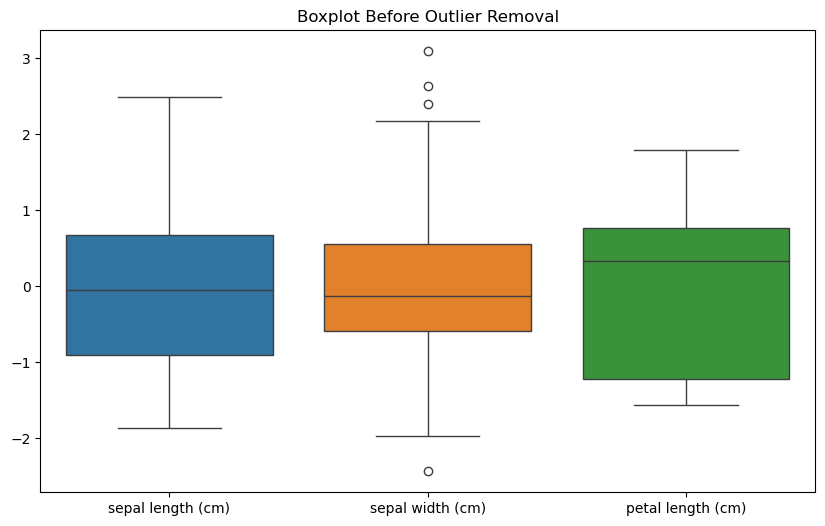

In [107]:
# with outleirs
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_reduced)
plt.title("Boxplot Before Outlier Removal")
plt.show()

In [108]:
# Use IQR to remove outliers
Q1 = X_reduced.quantile(0.25)
Q3 = X_reduced.quantile(0.75)
IQR = Q3 - Q1

# Boolean mask for non-outliers
non_outliers = ~((X_reduced < (Q1 - 1.5 * IQR)) | (X_reduced > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter data
X_no_outliers = X_reduced[non_outliers]
y_no_outliers = y[non_outliers]

print(f"Removed {len(X_reduced) - len(X_no_outliers)} outliers.")

Removed 4 outliers.


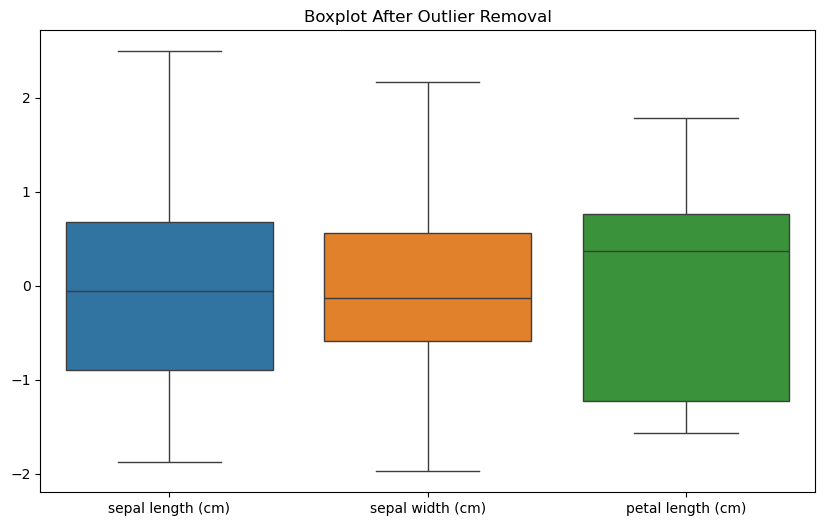

In [109]:
# Boxplot after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_no_outliers)
plt.title("Boxplot After Outlier Removal")
plt.show()

In [190]:
import statsmodels.api as sm

X_base = sm.add_constant(X_clean)
model = sm.MNLogit(y_clean, X_base)
result = model.fit(disp=False)

In [117]:
pred_probs = result.predict(X_base)
residuals = y_clean - pred_probs.values.argmax(axis=1)

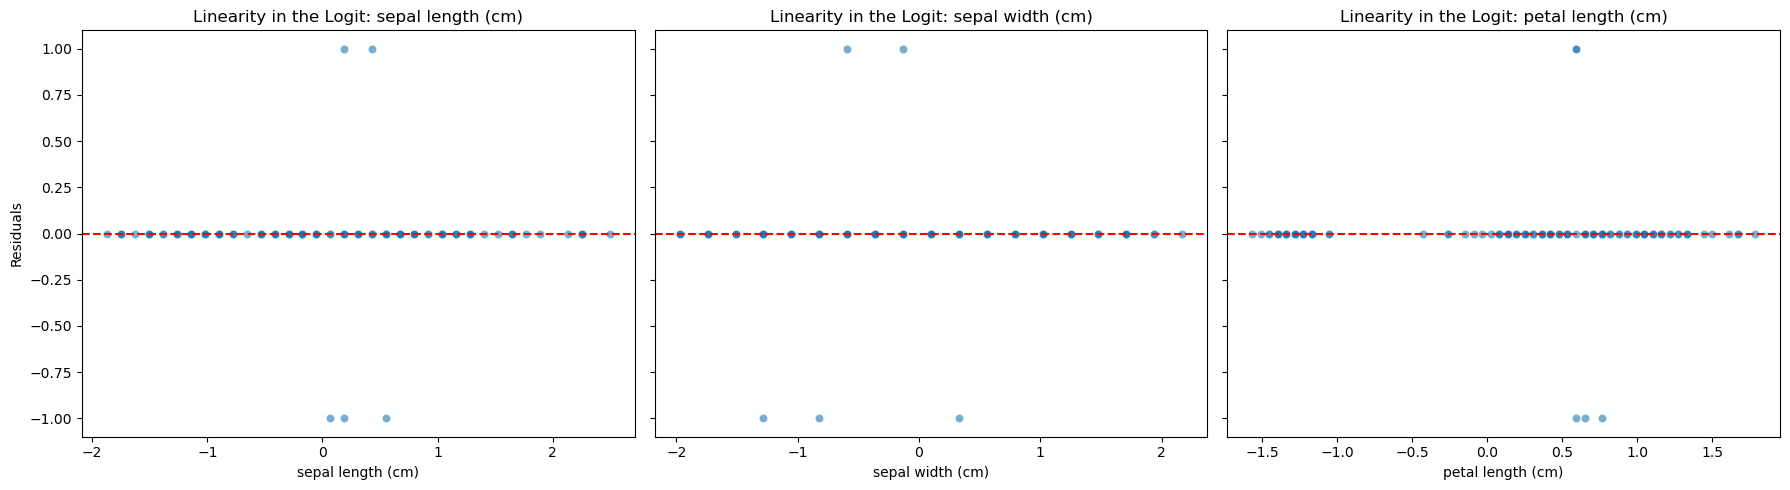

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# feature plots
features = X_clean.columns

for i, col in enumerate(features):
    sns.scatterplot(x=X_clean[col], y=residuals, ax=axes[i], alpha=0.6)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f"Linearity in the Logit: {col}")
    axes[i].set_xlabel(col)
    if i == 0:
        axes[i].set_ylabel("Residuals")
    else:
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()


In [197]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)

# Standardize
scaler = StandardScaler()
X_clean = scaler.fit_transform(X)


In [198]:
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

kmeans = KMeans(n_clusters=3, random_state=25)
clusters = kmeans.fit_predict(X_clean)

for i in range(residuals.shape[1]):
    f_stat, p_val = f_oneway(*[residuals[clusters == k, i] for k in range(3)])
    print(f"Class {i}: F={f_stat:.4f}, p_val={p_val:.4f}")


Class 0: F=2.2637, p_val=0.1076
Class 1: F=0.6515, p_val=0.5228
Class 2: F=0.6515, p_val=0.5228


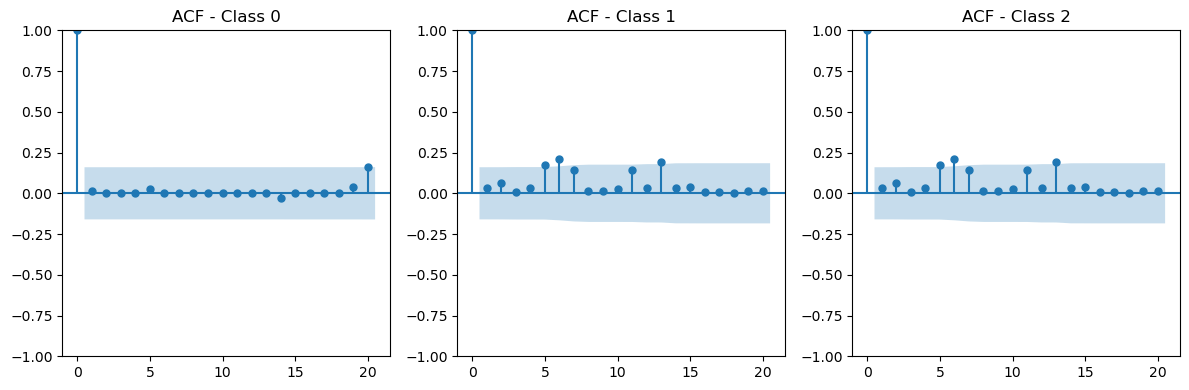


Class 0 ACF values:
[ 1.00000000e+00  1.40514742e-02  2.87502413e-04  3.41951578e-04
 -3.55166752e-05  2.68219240e-02 -3.32911030e-05 -3.30504954e-05
 -1.83885253e-05 -3.61834688e-05 -3.74388271e-05 -3.75600866e-05
  2.96753244e-05 -9.73822161e-04 -2.71878783e-02 -3.64766439e-05
 -6.38895172e-05  1.01217165e-03  1.45028369e-04  4.09064240e-02
  1.58621971e-01]

Class 1 ACF values:
[1.00000000e+00 3.45583515e-02 6.44948143e-02 7.84216261e-03
 3.54122605e-02 1.73844374e-01 2.12152128e-01 1.45378534e-01
 1.22730428e-02 1.47253860e-02 2.38143269e-02 1.44031710e-01
 3.14439929e-02 1.92088647e-01 3.50981051e-02 3.85538740e-02
 1.10524958e-02 5.78482591e-03 4.99684099e-04 1.42898765e-02
 1.11137165e-02]

Class 2 ACF values:
[1.00000000e+00 3.45583515e-02 6.44948143e-02 7.84216261e-03
 3.54122605e-02 1.73844374e-01 2.12152128e-01 1.45378534e-01
 1.22730429e-02 1.47253860e-02 2.38143269e-02 1.44031710e-01
 3.14439929e-02 1.92088647e-01 3.50981051e-02 3.85538738e-02
 1.10524958e-02 5.78482591e-

In [193]:
iris = load_iris() #ima reload
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="species")

# scale feats
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_const = sm.add_constant(X_scaled)

# model fit
model = sm.MNLogit(y, X_const).fit(disp=False)
y_pred_probs = model.predict(X_const) 

# get resideuals
residuals = np.zeros_like(y_pred_probs)
for i in range(y_pred_probs.shape[1]):
    residuals[:, i] = (y == i).astype(int).values - y_pred_probs[:, i]

# plot autocorr
acf_values = {}
plt.figure(figsize=(12, 4))
for i in range(residuals.shape[1]):
    acf_class = acf(residuals[:, i], nlags=20, fft=True)
    acf_values[f"Class {i}"] = acf_class
    plt.subplot(1, 3, i + 1)
    plot_acf(residuals[:, i], lags=20, ax=plt.gca(), title=f"ACF - Class {i}")
plt.tight_layout()
plt.show()

for k, v in acf_values.items():
    print(f"\n{k} ACF values:\n{v}")

In [200]:
iris = load_iris()
X = iris.data
y = iris.target

y_binary = (y == 0).astype(int)  # Class 0 vs others


model = LinearRegression().fit(X, y_binary)
residuals = y_binary - model.predict(X)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)

print(f"Durbin-Watson statistic: {dw_stat:.4f}")

Durbin-Watson statistic: 0.8227


In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('./iris.csv')

In [3]:
df = df.drop(['Unnamed: 0', 'petal_width'], axis=1) # drop col 1 (index) drop petal width due to multicolinearity

In [4]:
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])


In [5]:
X = df.drop(['species', 'species_encoded'], axis=1)
y = df['species_encoded']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split: 80/10/10
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=25, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=25, stratify=y_temp)


In [12]:
# Define param_grid for 'saga' solver (which can use 'elasticnet' penalty)
param_grid_saga = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['elasticnet'],  # Only 'elasticnet' for saga
    'solver': ['saga'],         # 'saga' solver is needed for elasticnet
    'l1_ratio': [0.1, 0.5, 0.9],  # l1_ratio needed for elasticnet
    'max_iter': [1000, 5000, 10000],
}

# Define param_grid for 'l2' penalty (which works with 'lbfgs' and 'newton-cg')
param_grid_l2 = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # Only 'l2' penalty here
    'solver': ['lbfgs', 'newton-cg'],  # These solvers support 'l2' penalty
    'max_iter': [1000, 5000, 10000],
}

# Combine both grids into a list
param_grid = [param_grid_saga, param_grid_l2]

# Initialize the GridSearchCV with LogisticRegression
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

# Fit the model on your training data
grid.fit(X_train, y_train)

# Retrieve the best model
best_model = grid.best_estimator_

Best Parameters: {'C': 1, 'l1_ratio': 0.9, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}


D:\Anaconda_Navigator\envs\data_sci\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [13]:
best_model

LogisticRegression(C=1, l1_ratio=0.9, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [ ]:
best_model.n_iter_

In [ ]:
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)

# Confusion matrix and coefficients
conf_matrix_df = pd.DataFrame(
    confusion_matrix(y_val, y_pred),
    index=le.classes_,
    columns=[f'Predicted {label}' for label in le.classes_]
)

coef_df = pd.DataFrame(
    best_model.coef_,
    columns=X.columns,
    index=le.classes_
)
coef_df["Intercept"] = best_model.intercept_

In [ ]:
# sample prediction should be class Iris setosa
sample_raw_df = pd.DataFrame([[5.1, 3.5, 1.4]], columns=X.columns)
sample_scaled = scaler.transform(sample_raw_df)

# logits 
logits = best_model.coef_ @ sample_scaled.T + best_model.intercept_.reshape(-1, 1)
logits = logits.flatten()

# Softmax
exp_logits = np.exp(logits)
probs = exp_logits / np.sum(exp_logits)


In [ ]:
# echo results
prediction = {
    "Raw Input": sample_raw_df.values.flatten().tolist(),
    "Standardized Input": sample_scaled.flatten().tolist(),
    "Logits": logits.tolist(),
    "Exp(Logits)": exp_logits.tolist(),
    "Probabilities": probs.tolist(),
    "Predicted Class Index": int(np.argmax(probs)),
    "Predicted Class Label": le.classes_[int(np.argmax(probs))]
}

{
    "Confusion Matrix": conf_matrix_df,
    "Coefficients and Intercepts": coef_df,
    "Prediction for [5.1, 3.5, 1.4]": prediction,
    "Validation Accuracy": accuracy_score(y_val, y_pred),
    "Log Loss": log_loss(y_val, y_pred_proba)
}

In [ ]:
conf_matrix_df

In [ ]:
coef_df

In [ ]:
prediction

In [ ]:
list(prediction.items())[:2]

In [ ]:
prediction.keys()

In [ ]:
pd.set_option('display.precision', 16)
pd.set_option('display.max_colwidth', None)

prediction_df = pd.DataFrame(list(prediction.items()),columns=['Metric', 'Value'])
prediction_df

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_log_loss = log_loss(y_test, y_test_pred_proba)
test_conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_test_pred),
    index=le.classes_,
    columns=[f"Predicted {label}" for label in le.classes_]
)

{
    "Test Accuracy": test_accuracy,
    "Test Log Loss": test_log_loss,
    "Test Confusion Matrix": test_conf_matrix
}

In [ ]:
test_conf_matrix

In [ ]:
coef_df

--end--